<a href="https://colab.research.google.com/github/UtkarshC99/me212-course-project/blob/main/Project_190107080.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Compressive Vertical Columns

    (Utkarsh Chaturvedi
    190107080
    Chemical Engineering)

The aim of this notebook is to analyse various column configurations and cross-sections to find out **the maximum height that can be achieved by a vertical column while being loaded to the maximum (i.e. yielding) stress** for the material.

The key assumptions of the Euler Buckling Theory are: 
1. The column is *massless*.
2. The material and cross-section of the column is *homogeneous* and *uniform*.
3. The column is a *slender* column, that is:
$$\frac{L_{\text{eff}}}{r}\geq 12$$
$$\text{(where 'r' is a cross-sectional dimension)}$$

Note that because we are considering lengths for which **`buckling stress = yielding stress`**, the slender column assumption may not hold everytime. Thus, the formulation serves to demonstrate an *upper limit* to the length of the column.

## Motivation

Space elevators are the next 'big thing' in human space exploration. By utilising a motorised lift platform that can lift people, vehicles and supplies from the surface to Earth orbit, there can potentially be a massive reduction in costs for the space industry.

<img src="https://www.engineersrule.com/wp-content/uploads/2016/02/1-1.jpg" width="200">

*(image source: https://www.engineersrule.com)*

Most concepts for space elevators use a *tensile* model, as the compressive model of erecting a building thousands of kilometers in height was deemed too unrealistic and impractical even with the strongest of materials available to humanity today. This project will demonstrate why the compressive space elevator model was rejected.

## Euler's Critical Load, and Maximum Possible Fully-Loaded Height

According to the Euler model of buckling, the critical load is given by:
$$P_\text{cr} = \frac{\pi^{2}EI}{L_{\text{eff}}^{2}}$$
Where:
$$L_{\text{eff}} = KL = \text{column effective length}$$
$$E = \text{Young's Modulus; }I = \text{Area Moment of Inertia}$$

Thus, the critical *stress* will be given by:
$$\sigma_{\text{cr}} = \frac{\pi^{2}EI}{L_{\text{eff}}^{2}A} = \frac{\pi^{2}EI}{K^{2}L^{2}A}\text{; where } A = \text{cross-section area}$$
<br>
$$\Rightarrow L = \frac{\pi}{K}\sqrt{\frac{EI}{\sigma{}A}}$$

Buildings typically use a Factor of Safety equal to 2, but that is in structures with redundant members. Thus, I shall use a `FoS` of 4 here, since a discrete column is being considered.
$$\text{FoS} = \frac{\sigma_{\text{yield}}}{\sigma_{\text{allow}}}\Rightarrow \sigma_{\text{allow}} = \frac{\sigma_{\text{yield}}}{4}$$

Since we require the column's length at the point where the material reaches its elastic limit i.e. for a column that is at the limit of it's structural integrity:
$$\therefore L_{\text{max}} = \frac{2\pi}{K}\sqrt{\frac{EI}{\sigma_{\text{yield}}A}}$$

Thus, this is the length of column, beyond which it will buckle at a stress LESSER than the maximum allowed stress. Therefore, it is ***the maximum height at which the bar can be FULLY loaded within safety constraints***.

## Importing Libraries

I will use NumPy for the mathematics, Matplotlib for plotting the functions (mpl_toolkits and mpatches are for creating interactible 3D plots and custom legends respectively), and IPyWidgets for user interactibility with the notebook and the functions I have created.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline
import ipywidgets as ipw

The following cell is used to set the style of the interactible widgets in order to improve legibility. I will define it once, and call it with the assigned name `style` hereafter.

In [2]:
style = {'description_width': 'initial'} # setting style for the widgets throughout the notebook to prevent redundancy

## Configuration of the Column

The configuration of the beam is an important component of the process of calculating the buckling stress. The below image from the notes highlights the differences between the 4 different configurations:

![Configuration of Columns - Buckling (source: Lecture 21)](https://i.paste.pics/6f07ae03de9c1c8683a02219b4fa74be.png?trs=04c7fd117719350699b836faaaebbc72e186673da2d68ff9cd19e41c0c0b58ef)

*(image source: Lecture 21, Slide 6)*

Note that "pinned" here has the same meaning as "hinged", and it refers to the end which is not firmly jointed to the floor or ceiling. It is different from a "free" end, in that it isn't free to translate.

The function defined below will take user input to figure out what the coefficient **`K`** of **`L`** should be, in the equation:
$$L_{\text{eff}} = KL$$

In [3]:
configurations = ['fixed at BOTH ends', 'hinged at BOTH ends', 
                  'hinged at an end, fixed at other', 'free at an end, fixed at other']

def l_eff_factor(config):
    
    if config == configurations[0]:
        k = 0.5
    elif config == configurations[1]:
        k = 1
    elif config == configurations[2]:
        k = 1/np.sqrt(2)
    elif config == configurations[3]:
        k = 2

    return k

## Defining the Cross-Section of the Column

For the purposes of this investigation, I will consider three cross-sections.

1. A **rectangular** cross-section, with defined **base** (`b`) and **width** (`h`). 
$$I_{\text{rect}} = \frac{bh^{3}}{12} \text{; } A_{\text{rect}} = bh$$
<br>
2. An **annular** cross-section, with an **outer radius** (`R`) and **inner radius** (`r`). 
$$I_{\text{tube}} = \frac{\pi}{4}(R^{4} - r^{4}) \text{; } A_{\text{tube}} = \pi(R^{2} - r^{2})$$
<br>
3. A **symmetrical I-beam** made of ***three equal-area pieces*** (2 flanges and 1 web). Thus, the relevant dimensions are **flange (or web) length** (`h`) and **flange (or web) thickness** (`t`).
$$I_{\text{I-beam}} = \frac{ht(t^{2} + 2h^{2})}{12}\text{; } A_{\text{I-beam}} = 3ht$$

For the purposes of this function, I shall take 2 parameters **`a`** and **`b`**, which mean different quantities as per the user input. The function is defined in such a way that it takes care of differences in magnitude between the two parameters, *i.e., if the user specifies that the cross-section is annular, then  the smaller one automatically becomes the inner radius `r`. Similarly, for an I-beam the smaller value becomes the flange thickness and the larger one becomes the flange length.*

Moreover, since the exercise of calculating buckling stress requires the calculation of the least possible value (if there are 2 or more polar axes for the cross-section), this will require another step of checking. This is also taken into account for all 3 cross-sections.

In [4]:
def dummy(name):
    return name

shapes = ['rectangular', 'annular', 'symmetrical I-beam']

def cross_sec(a, b, sec):
    if sec == shapes[0]:
        area = a*b
        if a >= b:
            inertia = (a)*(b**3)/12
        else:
            inertia = (a**3)*(b)/12
        ratio = inertia/area
    elif sec == shapes[1]:
        if a > b:
            area = (np.pi)*((a**2) - (b**2))
            inertia = 0.25*area*((a**2) + (b**2))
            ratio = inertia/area
        elif b > a:
            area = (np.pi)*((b**2) - (a**2))
            inertia = 0.25*area*((a**2) + (b**2))
            ratio = inertia/area
        else:
            ratio = 0
            area = 0
            inertia = 0
    elif sec == shapes[2]:
        area = 3*a*b
        if a >= b:
            inertia = a*b*((b**2) + (2*(a**2)))/12
        else:
            inertia = a*b*((a**2) + (2*(b**2)))/12
        ratio = inertia/area
            
    return ratio, area, inertia

Definiting the max length function, as derived earlier. Note that since **`E`** will be taken in **GPa**, **`S`** in **MPa**, and **`a`** & **`b`** in **mm** later on in the code, necessary conversions will be required. Also, a safety factor of 4 has been considered while deriving the equation.

In [5]:
def max_length(K, R, E, S):
    l = ((2*np.pi)/K)*np.sqrt((E/S)*(R))/(10**1.5)
    return l

## Defining a Pipeline

The following cells create interactible objects that will be used later to tweak the parameters of the `max_length` function defined above. Care has been take to make the units of the physical quantities homogeneous.

#### 1. Configuration of the beam and shape of cross-section

In [6]:
config = ipw.Dropdown(options = configurations, value = 'fixed at BOTH ends', 
                  description = "Beam Configuration:", 
                  style = style)
shape = ipw.Dropdown(options = shapes, value = 'rectangular', 
                  description = "Cross-Section:", 
                  style = style)
k_eff = ipw.interactive(l_eff_factor, config = config)
shape_code = ipw.interactive(dummy, name = shape)
ui_config = ipw.HBox([k_eff, shape_code])

#### 2. Dimensions of cross-section (mm)

In [7]:
a_field = ipw.FloatText(value = 1000, description = 'Parameter \'a\' in mm: ', style = style)
b_field = ipw.FloatText(value = 1000, description = 'Parameter \'b\'in mm: ', style = style)

a_int = ipw.interactive(dummy, name = a_field)
b_int = ipw.interactive(dummy, name = b_field)
ui_cross_section = ipw.HBox([a_int, b_int])

#### 3. Young's Modulus (GPa) and yield strength (MPa)

In [8]:
# 3. choosing Young's Modulus (GPa) and yield strength (MPa)
E_field = ipw.FloatText(value = 70, description = 'Young\'s Modulus (GPa): ', style = style)
S_field = ipw.FloatText(value = 275, description = 'Yield Strength (MPa): ', style = style)
E_int = ipw.interactive(dummy, name = E_field)
S_int = ipw.interactive(dummy, name = S_field)
ui_material_ppt = ipw.HBox([E_int, S_int])

ui_final = ipw.VBox([ui_config, ui_cross_section, ui_material_ppt])

## Executing the Pipeline

The following cell shows the interactible widget where the parameters of the length expression can be tweaked. To see the result after tweaking the values, the below 2 cells should be executed in succession. Please note that the cross-section dimensions are in `mm`, and the material properties chosen as defaults are those of Aluminium.

In [9]:
# 4. calculating length of column
display(ui_final)

In [10]:
K = l_eff_factor(config = k_eff.children[0].value)
a = a_int.children[0].value
b = b_int.children[0].value
R, A, I = cross_sec(a, b, sec = shape_code.children[0].value)
E = E_int.children[0].value
S = S_int.children[0].value

l_trial = max_length(K, R, E, S)
print('The maximum fully-loaded length of the column is ~', '{:.3f}'.format(l_trial), 'metres.')
print('The supported load is ', S*A, ' N, which is equivalent to ', S*A/9.81, 'kilograms at the Earth\'s surface.')
print('The slenderness ratio is ', K*l_trial/np.sqrt(R*(10**-6)))

The maximum fully-loaded length of the column is ~ 57.876 metres.
The supported load is  275000000.0  N, which is equivalent to  28032619.77573904 kilograms at the Earth's surface.
The slenderness ratio is  100.24495874524781


***Thus it is clear that even a solid Aluminium column with a square `1m`x`1m` cross-section barely reaches to `58` metres in height before buckling at maximum allowed stress for the material and safety considerations.***

## Verifying for Different Materials

For a space elevator, the upper end must be left free, while the lower one will be fixed to the ground. Considering a single column, the maximum possible length based on geometric and material properties can be found out.

We know,
$$K = 2$$
$$\Rightarrow L_{\text{eff}} = 2L$$

For the sake of comparison, assume that the structure supports a space station of mass `1000 tonnes` (or as heavy as two-and-a-half International Space Stations).
$$P_\text{cr} = \frac{\pi^{2}EI}{{2L}^{2}}$$
$$\text{But } P_{\text{cr}} = 9.81\times10^{6} N\text{, and } \sigma = \frac{P_{\text{cr}}}{A}$$
$$\text{Additionally } \sigma_{\text{}} \leq \sigma_{\text{allow}}$$
$$\therefore L = \frac{\pi}{2}\sqrt{\frac{EI}{P_{\text{cr}}}} \approx 5.015\times10^{-4}\sqrt{EI}$$

In [11]:
def spacescraper(E, I):
    l = 5.015*(10**(-4))*((E*I*0.001)**(0.5))
    return l

def comparison(E, S, K = 2):
    map_x00 = []
    map_x01 = []
    map_y0 = []
    map_x10 = []
    map_x11 = []
    map_y1 = []
    map_x20 = []
    map_x21 = []
    map_y2 = []
    area_0 = []
    area_1 = []
    area_2 = []

    for param_a in range(1, 10000, 250):
        for param_b in range(1, 10000, 250):
            for i in range(len(shapes)):
                R, A, I = cross_sec(param_a, param_b, shapes[i])
                y = spacescraper(E, I)
                if i == 0:
                    map_x00.append(param_a)
                    map_x01.append(param_b)
                    map_y0.append(y)
                    area_0.append(A)
                if i == 1:
                    map_x10.append(param_a)
                    map_x11.append(param_b)
                    map_y1.append(y)
                    area_1.append(A)
                if i == 2:
                    map_x20.append(param_a)
                    map_x21.append(param_b)
                    map_y2.append(y)
                    area_2.append(A)
                    
    fig = plt.figure(figsize = (10, 8))
    ax = fig.add_subplot(111, projection = '3d')
    ax.set_xlabel('Parameter a (mm)')
    ax.set_ylabel('Parameter b (mm)')
    ax.set_zlabel('Max fully-loaded length (m)');
    ax.scatter(map_x00, map_x01, map_y0, c = 'r')
    ax.scatter(map_x10, map_x11, map_y1, c = 'c')
    ax.scatter(map_x20, map_x21, map_y2, c = 'k')
    patch_rec = mpatches.Patch(color = 'r', label = 'Rectangular')
    patch_tube = mpatches.Patch(color = 'c', label = 'Annular')
    patch_eye = mpatches.Patch(color = 'k', label = 'Symmetrical I-Beam')
    plt.legend(handles = [patch_rec, patch_tube, patch_eye], bbox_to_anchor=(1.001, 1), loc='upper left', prop = {'size' : 10})
    plt.title(label = 'E = ' + str(E) + 'GPa, S = ' + str(S) + 'MPa')
    plt.show()    

### 1. Steel (E = 200 GPa, S = 152 MPa)*
    *(source: http://www.matweb.com/search/datasheet_print.aspx?matguid=d1844977c5c8440cb9a3a967f8909c3a)
We can clearly see that an annular cross-section outperforms the other two cross-sections. With an outer radius of ***`~10 m`*** and a negligible inner radius, the height of the free-ended annular **steel** column reaches ***`~18 km`***. This cross-section is unsuitable for buildings, but for a space elevator, this is a feasible size. 

On first glance, this may appear to be a satisfactory result. However, a closer look at the stress ***reveals that this far exceeds the compressive strength of steel.*** Thus, while mathematically sound, this structure is physically impossible as it will crumble under the weight of the proposed space station. Moreover, **`18 km`** isn't that impressive for a space station.

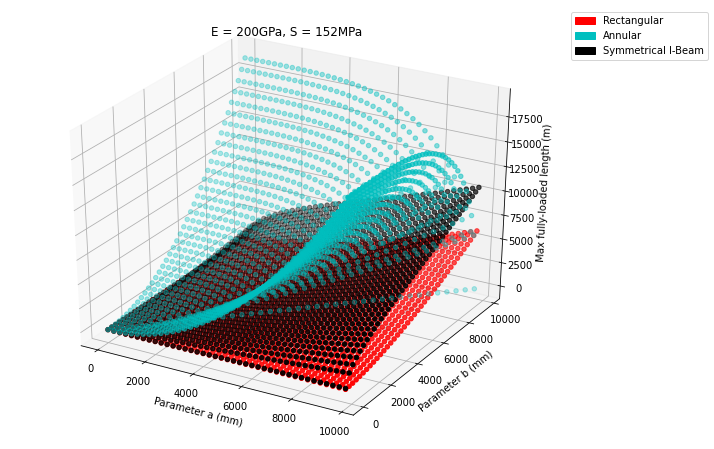

In [12]:
comparison(E = 200, S = 152)

### 2. Diamond [E = 1220 GPa, S = 60 GPa = 60,000 MPa (compressive)]

Diamond is extremely expensive, and thus not a feasible material to built kilometers of compressive space elevator structures with. It is one of the largest, and diamond nanowires are reported to reach compressive strengths of upto **`100 GPa`**. Upon analysing, we find that the structure is predicted to reach a maximum height of **`~50 km`**, but again, as noted in the case of steel, the stress on the column would be massive even without considering the weight of the column itself. 

This makes the actual maximum far lesser than 50 km, although ***this value would be higher for diamond that for steel, due to its much higher compressive strength.***

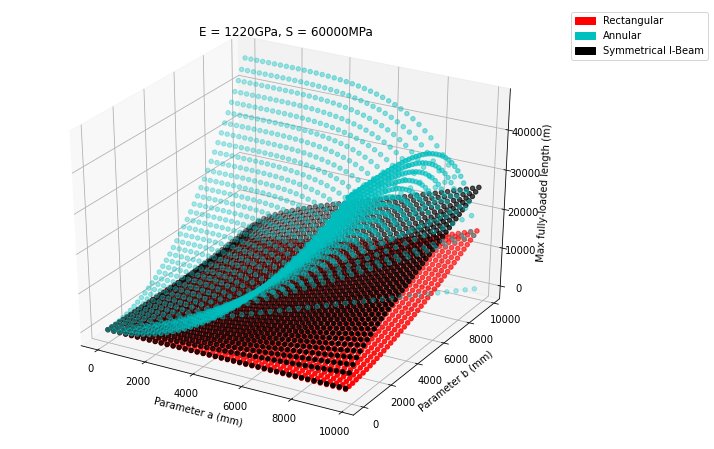

In [13]:
comparison(E = 1220, S = 60000)